In [20]:
import importlib
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import itertools
import pandas as pd

import utils
from utils.download import get_data
from utils.var import calculate_var, exceeds_vector
from utils.methods import weighted_var, garch_var
from utils.tests import scoring_expectile

In [21]:
_ = importlib.reload(utils.download)
_ = importlib.reload(utils.var)

In [22]:
raw_data, params = get_data(yahoo=False)

[*********************100%%**********************]  1 of 1 completed


In [23]:
frequency = params['frequency']

In [24]:
data = raw_data.resample(frequency).last()

In [25]:
data['returns'] = data.interpolate(type='linear').pct_change()

# Metoda historyczna

In [26]:
data = calculate_var(data, lambda x: stats.expectile(x, .95), 'hist')
data = calculate_var(data, lambda x: stats.expectile(x, .99), 'hist', 99)

Wykres zwrotów i VaR95 dla zwrotów.

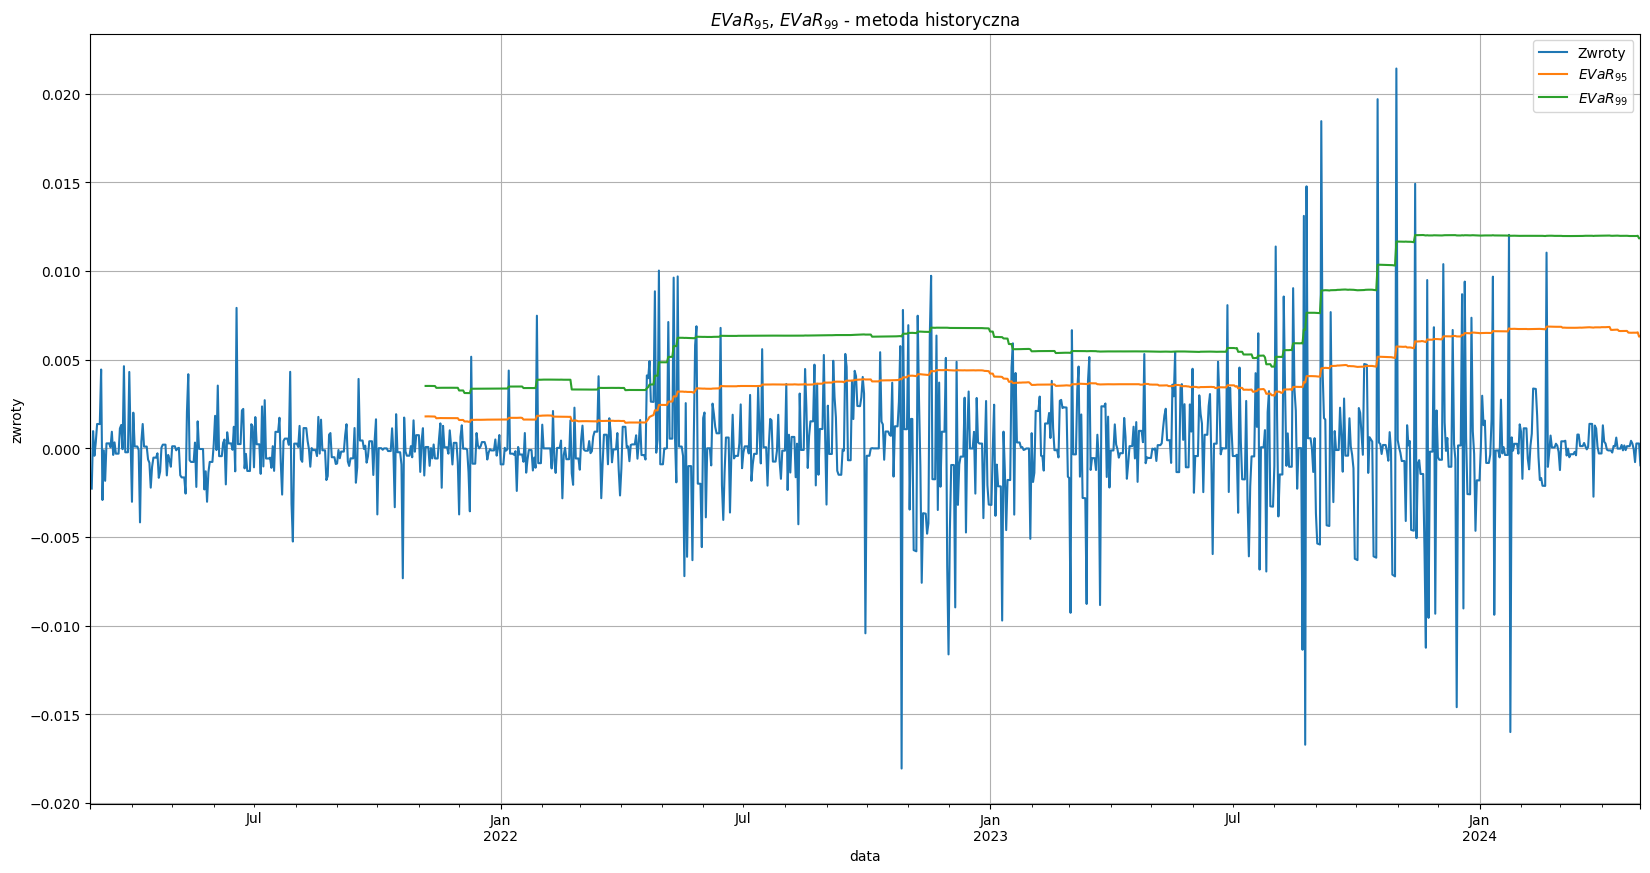

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_hist', 'var99_hist']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$EVaR_{95}$')
plt.legend(['Zwroty', '$EVaR_{95}$'])
plt.savefig(f"pics\\{params['name']}\\evar95.png")

In [28]:
data, I95 = exceeds_vector(data, 'hist')  # I - wektor przekroczeń
data, I99 = exceeds_vector(data, 'hist', 99)

## Testowanie wsteczne

In [29]:
pd.set_option("display.precision", 10)

S95 = scoring_expectile(data.returns, data.var95_hist, .95)
S99 = scoring_expectile(data.returns, data.var99_hist, .99)

scoring_df = pd.DataFrame({'historyczna': [np.mean(S95), np.mean(S99)]}, index=[0.95, 0.99])
scoring_df

,historyczna
0.95,0.0000030329
0.99,0.0000012566


# Metoda ważonej symulacji historycznej

In [30]:
data = calculate_var(data, lambda x: weighted_var(x, .95), 'ważona')
data = calculate_var(data, lambda x: weighted_var(x, .99), 'ważona', 99)

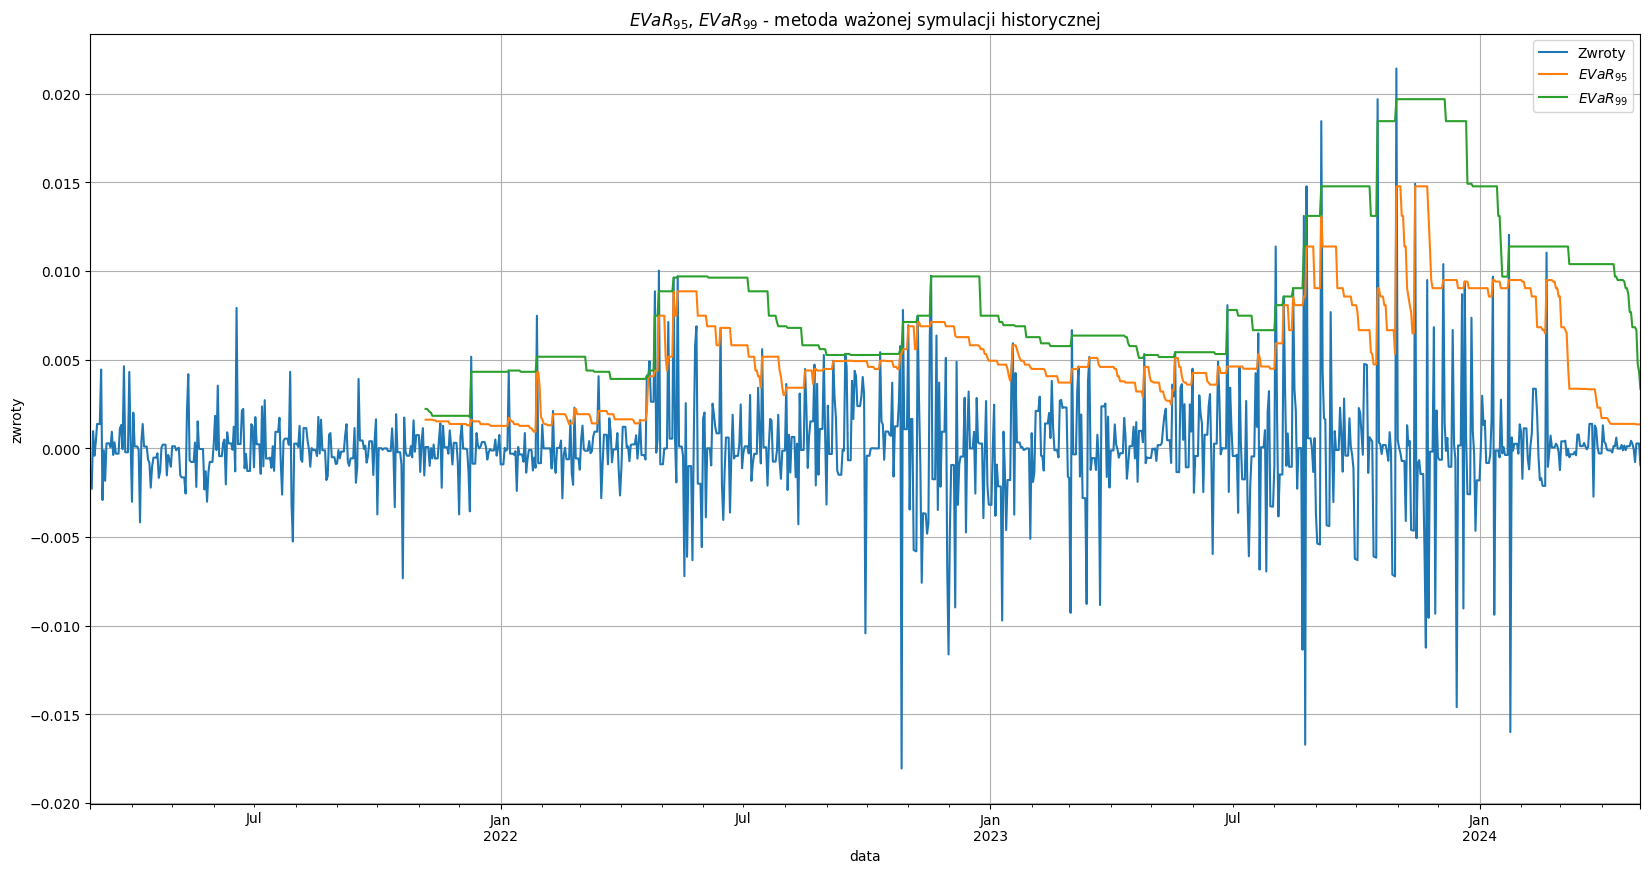

In [31]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_ważona','var99_ważona']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$EVaR_{95}$',
         color=['C0', 'C1', 'C2'])
plt.legend(['Zwroty', '$EVaR_{95}$', '$EVaR_{95}$ - metoda ważona'])
plt.savefig(f'pics\\{params["name"]}\\evar95_wazony.png')

In [32]:
data, I95_weighted = exceeds_vector(data, 'ważona')
data, I99_weighted = exceeds_vector(data, 'ważona', 99)

## Testowanie wsteczne

In [33]:
S95_weighted = scoring_expectile(data.returns, data.var95_ważona, .95)
S99_weighted = scoring_expectile(data.returns, data.var99_ważona, .99)

scoring_df['ważona'] =  [np.mean(S95_weighted), np.mean(S99_weighted)]
scoring_df

,historyczna,ważona
0.95,0.0000030329,0.0000026075
0.99,0.0000012566,0.0000010387


# Metoda filtrowanej symulacji historycznej

In [34]:
%%capture
data = calculate_var(data, lambda x: garch_var(x, .95), 'garch', 95)
data = calculate_var(data, lambda x: garch_var(x, .99), 'garch', 99)

In [ ]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_garch','var99_garch']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$EVaR_{95}$, $EVaR_{99}$ - metoda filtrowanej symulacji historycznej',
         color=['C0', 'C1', 'C2'])
plt.legend(['Zwroty', '$EVaR_{95}$', '$EVaR_{99}$'])
plt.savefig(f'pics\\{params["name"]}\\evar_garch.png')

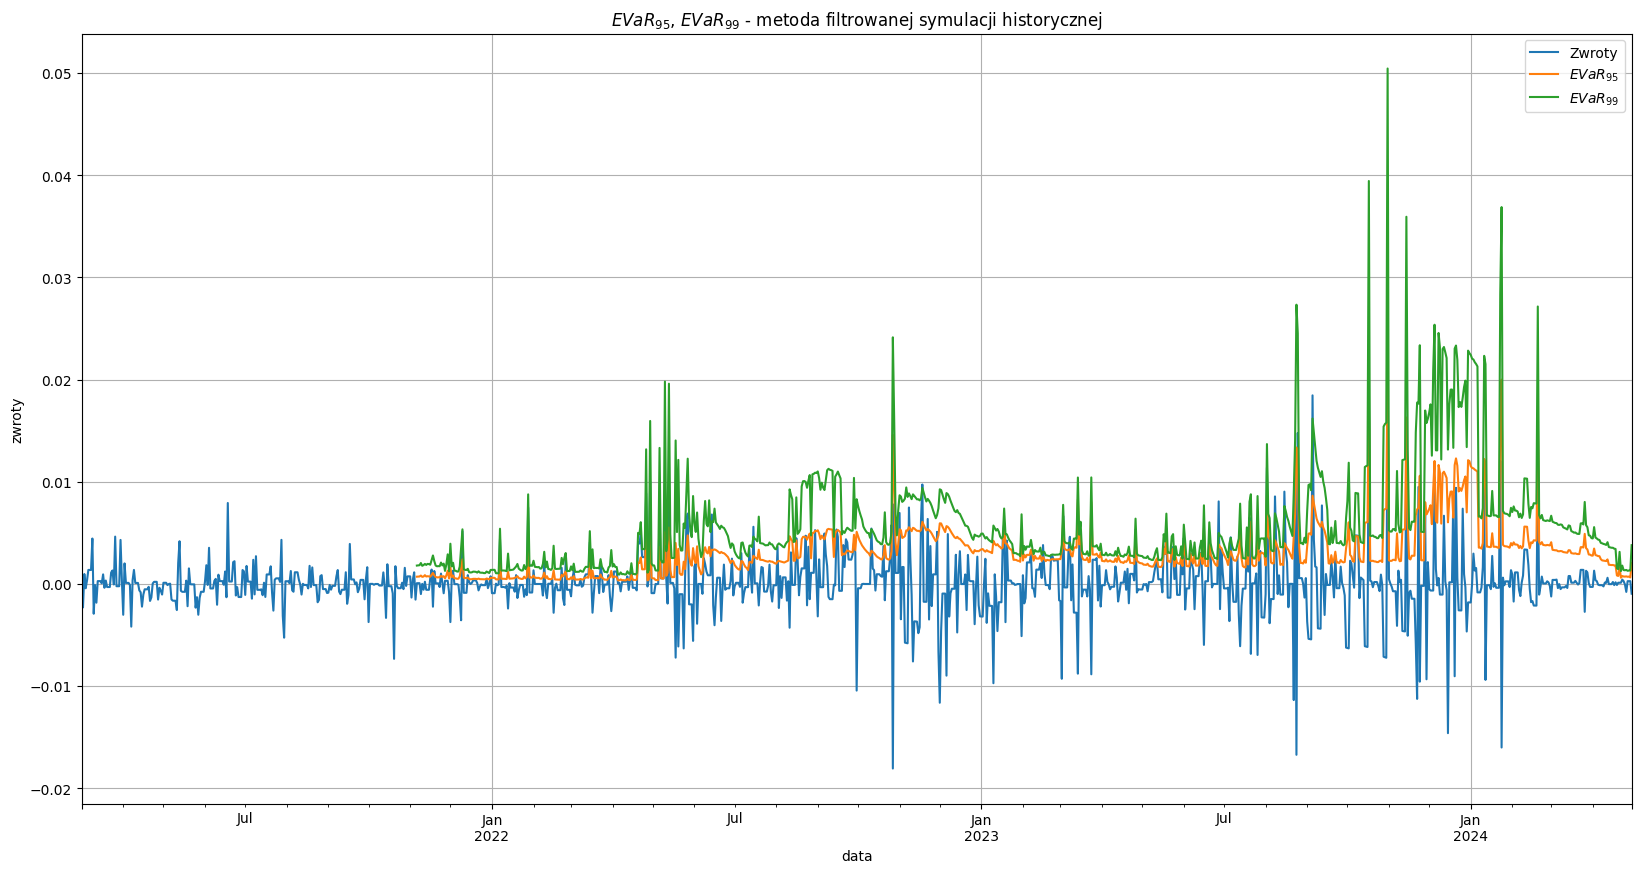

In [35]:
_, ax = plt.subplots(figsize=(20, 10))
_ = data[['returns', 'var95_hist', 'var95_ważona', 'var95_garch']].plot(ax=ax,
                                                                         grid=True,
                                                                         xlabel='data',
                                                                         title='$EVaR_{95}$ - porównanie trzech metod',
                                                                         color=['C0', 'C1', 'C2', 'C3'])
plt.legend(['Zwroty', '$EVaR_{95}$', '$EVaR_{95}$ - metoda ważona', '$EVaR_{95}$ - GARCH'])
plt.savefig(f'pics\\{params["name"]}\\evar_porównanie.png')

## Testowanie wsteczne

In [18]:
S95_garch = scoring_expectile(data.returns, data.var95_garch, .95)
S99_garch = scoring_expectile(data.returns, data.var99_garch, .99)

scoring_df['garch'] =  [np.mean(S95_garch), np.mean(S99_garch)]
scoring_df

,historyczna,ważona,garch
0.95,0.0000040669,0.0000031715,0.0000021825
0.99,0.0000017238,0.0000012922,0.0000009386


# Porównanie

In [19]:
S95s = {'historyczna': S95, 'ważona': S95_weighted,'garch': S95_garch}
S99s = {'historyczna': S99, 'ważona': S99_weighted,'garch': S99_garch}

H0: the samples are drawn from populations with the same population means.

In [20]:
for a, b in itertools.combinations(S95s.keys(), 2):
    print(f'{a} vs {b}\n{stats.ttest_ind(S95s[a], S95s[b])}')

historyczna vs ważona
TtestResult(statistic=1.173416952710349, pvalue=0.2408868788778358, df=1082.0)
historyczna vs garch
TtestResult(statistic=2.407927770458956, pvalue=0.016209856399970166, df=1082.0)
ważona vs garch
TtestResult(statistic=2.923781734484348, pvalue=0.003530107121202798, df=1082.0)


In [39]:
for a, b in itertools.combinations(S99s.keys(), 2):
    print(f'{a} vs {b}\n{stats.ttest_ind(S99s[a], S99s[b])}')

historyczna vs ważona
TtestResult(statistic=0.8675632680025982, pvalue=0.38574833821594423, df=1812.0)
historyczna vs garch
TtestResult(statistic=2.6730459397427078, pvalue=0.007584037264977208, df=1812.0)
ważona vs garch
TtestResult(statistic=3.453585161773385, pvalue=0.0005659119939542626, df=1812.0)


historyczna vs ważona
TtestResult(statistic=1.0758928515128723, pvalue=0.28211840816672934, df=1812.0)
historyczna vs garch
TtestResult(statistic=2.7992692915967723, pvalue=0.005176111250163693, df=1812.0)
ważona vs garch
TtestResult(statistic=4.699303587489485, pvalue=2.807350978198876e-06, df=1812.0)
